Proxies for internet access on the cluster:

In [1]:
Sys.setenv(http_proxy = "http://proxy-default:3128", 
           https_proxy = "http://proxy-default:3128")

Libraries:

In [2]:
library(tidyverse)
library(cowplot)

library(extrafont)
#font_import()
# loadfonts()

theme_set(theme_bw() + theme(text=element_text(size=15,
                                              # family="Arial"
                                              ), 
                             panel.grid.major = element_blank(),
                             panel.grid.minor = element_blank()
                            ) 
         )
despine <- theme(panel.border = element_blank(), axis.line = element_line(colour = "black"))
options(repr.plot.width=9, repr.plot.height=5)
figsize <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}
saveplot <- function(filename) {
    ggsave(filename, width=options()$repr.plot.width, height=options()$repr.plot.height)
}


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registering fonts with R



Test plot: 

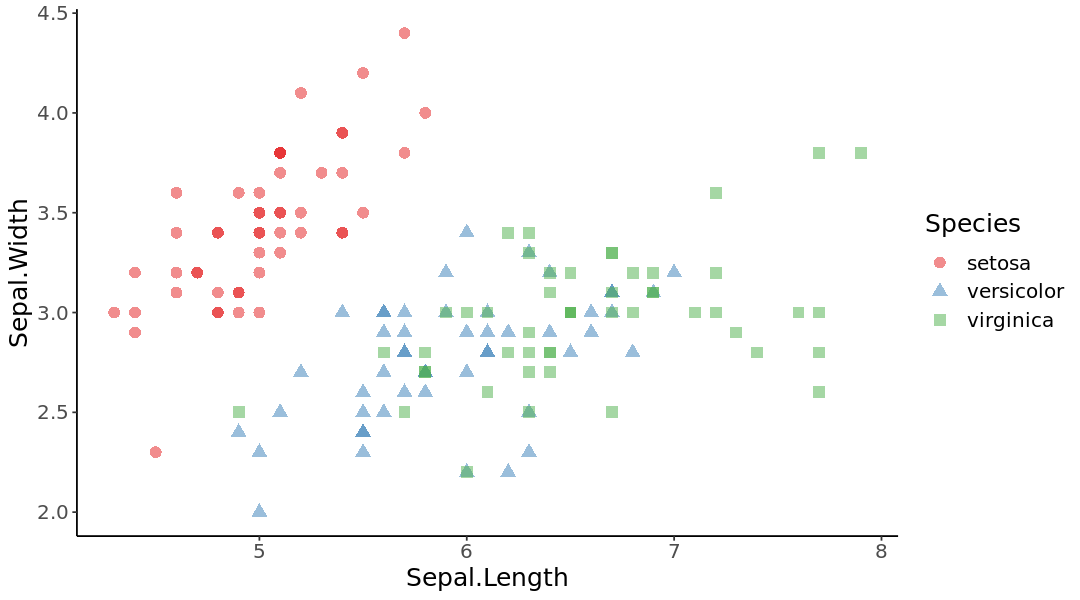

In [3]:
(ggplot(data=iris, aes(x = Sepal.Length, y = Sepal.Width))
 + geom_point(aes(color=Species, shape=Species), size=3, alpha=0.5) 
 + scale_color_brewer(palette="Set1") 
 + despine
 )

# PtDAlgorithms

In [4]:
library(devtools)
#remove.packages("ptdalgorithms")
devtools::install_github("TobiasRoikjer/PtDAlgorithms")
library(ptdalgorithms)

Indlæser krævet pakke: usethis

Skipping install of 'ptdalgorithms' from a github remote, the SHA1 (dfc78fe3) has not changed since last install.
  Use `force = TRUE` to force installation



In [5]:
# !export LIBS="-L/Users/kmt/miniconda3/envs/phasetype/lib"
# !export CPPFLAGS="-I/Users/kmt/miniconda3/envs/phasetype/include"

# IM model

Each state has the following three properties:
1. nr decendants in population 1
2. nr decendants in population 2
3. what population the lineage is currently in

In [6]:
Rcpp::sourceCpp("./isolation_migration.cpp")

In [7]:
graph <- construct_im_graph(4,4,1,1,0.1,0.1)
vertices_length(graph)

[1] 1432

In [8]:
# %%R
# for (i in 1:vertices_length(graph)) { edges(vertex_at(graph, i)) }

In [9]:
states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))

parents <- c()
children <- c()
rates <- c()
for (i in 1:vertices_length(graph)) {
    for (edge in edges(vertex_at(graph, i))) {
        parents <- c(parents, i)
        children <- c(children, edge$child$index)
        rates <- c(rates, edge$weight)
    }
}

Comparing results for numerical accuracy for an "infinite" IM stage

In [ ]:
n1 <- 6
n2 <- 6

g <- construct_im_graph(n1,n2,1,1,0.1,0.1)

expected_visits <- rep(0, vertices_length(g))
ctx <- distribution_context(g,1000)
while (distribution_context_state(ctx)$cdf < 0.9999) {
  distribution_context_step(ctx)
}
expected_visits <- distribution_context_accumulated_visiting_time(ctx)

distribution_expectation <- matrix(nrow=n1+1,ncol=n2+1)
algorithm_expectation <- matrix(nrow=n1+1,ncol=n2+1)
matrix_expectation <- matrix(nrow=n1+1,ncol=n2+1)
simulation_expectation <- matrix(nrow=n1+1,ncol=n2+1)
PH <- graph_as_matrix(g)
U <- solve(-PH$SIM)
set.seed(1234)

for (i in 0:n1) {
  for (j in 0:n2) {
    matrix_expectation[i+1,j+1] <-PH$IPV %*% U%*%diag(PH$states[,(matrix_index(i,j,0,n1,n2)+1)]+PH$states[,(matrix_index(i,j,1,n1,n2)+1)])%*%rep(1,length(PH$IPV))
    algorithm_expectation[i+1, j+1]<- expectation(g, rewards_at(g, i,j,n1,n2))
    distribution_expectation[i+1,j+1] <- sum(expected_visits * rewards_at(g, i,j,n1,n2))
    simulation_expectation[i+1, j+1]<- mean(rph(1000000, g, rewards_at(g, i,j,n1,n2)))
  }
}

print(sum(abs(matrix_expectation - algorithm_expectation)))
print(sum(abs(matrix_expectation - simulation_expectation)))
print(sum(abs(matrix_expectation - distribution_expectation)))

In [ ]:
figsize(7,5)
df <- as.data.frame(matrix_expectation - distribution_expectation) #%>% gather()
df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))
ggplot(df, aes(ton1, ton2)) +
  geom_tile(aes(fill = value)) + scale_y_discrete(labels= seq(1, 9)) 
saveplot('figures/mat_dist_diff.pdf')

In [ ]:
# plt.subplots(1, 1, figsize=(7, 5))
# ax = sns.heatmap(matrix_expectation - distribution_expectation, cmap="viridis_r", 
#                 annot=True
#                 )
# ax.invert_yaxis()

The complete IM model with a split time and ancestral population:

In [ ]:
# parameters
n1 <- 4
n2 <- 4
m1 <- 1
m2 <- 1
split_t <- 1.5 # time in whatever unit used to scale transition probs (N generations)

# build im graph
im_g <- construct_im_graph(n1,n2,1,1,0.1,0.1)
cat(vertices_length(im_g), "\n")

# create ancestral graph
a_g <- construct_ancestral_graph(n1,n2,1)
cat(vertices_length(a_g), "\n")


In [ ]:
# parameters
n1 <- 10
n2 <- 10
m12 <- 0.005
m21 <- 2
p1 <- 2
p2 <- 1
pa <- 4
split_t <- 3 # time in whatever unit used to scale transition probs (N generations)

# build im graph
im_g <- construct_im_graph(n1, n2, p1, p2, m12, m21)
cat(vertices_length(im_g), "\n")

im_expected_visits <- accumulated_visiting_time(im_g, split_t)

# create ancestral graph
a_g <- construct_ancestral_graph(n1, n2, pa)
cat(vertices_length(a_g), "\n")

# find probabilities of starting at each state in ancestral graph
start_prob <- start_prob_from_im(a_g, im_g, im_expected_visits)

# compute expectations for each graph
im_expectation <- matrix(nrow=n1+1,ncol=n2+1)
a_expectation <- matrix(nrow=n1+1,ncol=n2+1)
for (i in 0:n1) {
  for (j in 0:n2) {
    im_expectation[i+1,j+1] <- sum(im_expected_visits * rewards_at(im_g, i,j,n1,n2))
    a_expectation[i+1, j+1]<- sum(start_prob * expected_waiting_time(a_g, rewards_at(a_g, i,j,n1,n2)))
  }
}

In [ ]:
## pd.DataFrame(im_expectation).to_hdf(f'im_{int(n1)}_{int(n2)}_{float(m1)}_{float(m2)}_{float(split_t)}.h5', key='df', format='table')
pd.DataFrame(a_expectation).to_hdf(f'a_{int(n1)}_{int(n2)}.h5', key='df', format='table')

Expectation for inifinte IM stage:

In [ ]:
df <- as.data.frame(a_expectation)
rownames(df) <- seq(1, n1)
colnames(df) <- seq(1, n2)
df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))
figsize(7, 5.5)
ggplot(df, aes(ton1, ton2)) +
  geom_tile(aes(fill = value)) + scale_y_discrete(labels= seq(1, 9)) +
  geom_text(aes(label = round(value, 2))) +
  scale_fill_gradient2(low = "magenta4", high = "green4", midpoint = 0) + noframe
saveplot('figures/exp_infinite_im_stage.pdf')

In [ ]:
plt.subplots(1, 1, figsize=(7, 5))
ax = sns.heatmap(pd.DataFrame(im_expectation), cmap="viridis_r", 
#                annot=True
                )
ax.invert_yaxis()
plt.savefig('im_stage.pdf')

Expectation for panmictic ancestral population:

In [ ]:
plt.subplots(1, 1, figsize=(7, 5))
ax = sns.heatmap(a_expectation, cmap="viridis_r", 
#                annot=True
                 
                )
ax.invert_yaxis()
plt.savefig('a_stage.pdf')

Expectation for combined IM model with split time:

In [ ]:
plt.subplots(1, 1, figsize=(7, 5))
ax = sns.heatmap(im_expectation + a_expectation, cmap="viridis_r", 
                # annot=True,
                 linewidths=1,
                 linecolor='white'
                )
ax.invert_yaxis()
plt.savefig(f"im_{n1}_{n1}_{m12}_{m12}_{split_t}.pdf")
plt.savefig(f"im_{n1}_{n1}_{m12}_{m12}_{split_t}.png")

In [ ]:
plt.subplots(1, 1, figsize=(13, 10))
ax = sns.heatmap(im_expectation + a_expectation, cmap="viridis_r", 
                annot=True,
                linewidths=1,
                linecolor='white'
                )
ax.invert_yaxis()
plt.savefig(f"im_{n1}_{n1}_{m12}_{m12}_{split_t}_annot.pdf")
plt.savefig(f"im_{n1}_{n1}_{m12}_{m12}_{split_t}_annot.png")